In [1]:
from google.colab import drive
drive.mount('/content/drive')

#loading the dataset and extracting from the zip file
!unzip drive/My\ Drive/Fold2.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/18606-03544.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/80626-08860.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/82398-09746.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/96574-10632.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/32782-08860.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/101004-09746.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616BB-AC32-4A7E-B95C-5BEF8A95D1DF.svs/07088-04430.jpg  
  inflating: Fold2/Validation/Epithelioid/TCGA-ZN-A9VS-01A-01-TS1.950616B

In [2]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
from fnmatch import fnmatch

In [4]:
train_path = "Fold2/Train"
val_path = "Fold2/Validation"
test_path ="Fold2/Test"

batch_size = 64

loss_function ='categorical_crossentropy'
patience = 10
epoch = 50
final_activation ='softmax'
file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"


base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.summary()

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [5]:
def training_model(pretrained_model,final_activation):
    model = Sequential()
    model.add(pretrained_model) #pretrained model
    model.add(Flatten()) #creating a single 1-d vector
    model.add(Dense(2,activation=final_activation))#output layer with softmax activation function.
    return model

#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

def prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #AUC - ROC score
  false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  roc_auc_avg = auc(false_pr_avg,true_pr_avg)
  print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
  print("-----------------------------------------------------")
  plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
  
  false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  roc_auc_max = auc(false_pr_max,true_pr_max)
  print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
  print("-----------------------------------------------------")
  plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
 

def pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #presicion - recall curve
  precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
 
  print("-----------------------------------------------------")
  plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

  precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
 
  print("-----------------------------------------------------")
  plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

Epoch 1/50
648/648 [==============================] - 639s 987ms/step - loss: 0.7826 - auc: 0.6300 - precision: 0.5929 - recall: 0.5929 - val_loss: 1.7458 - val_auc: 0.2755 - val_precision: 0.2664 - val_recall: 0.2664
Epoch 2/50
648/648 [==============================] - 642s 991ms/step - loss: 0.6248 - auc: 0.7519 - precision: 0.6827 - recall: 0.6827 - val_loss: 0.8790 - val_auc: 0.5583 - val_precision: 0.5431 - val_recall: 0.5431
Epoch 3/50
648/648 [==============================] - 642s 991ms/step - loss: 0.5315 - auc: 0.8186 - precision: 0.7397 - recall: 0.7397 - val_loss: 0.8596 - val_auc: 0.5895 - val_precision: 0.5636 - val_recall: 0.5636
Epoch 4/50
648/648 [==============================] - 641s 989ms/step - loss: 0.4634 - auc: 0.8623 - precision: 0.7780 - recall: 0.7780 - val_loss: 0.7640 - val_auc: 0.6896 - val_precision: 0.6399 - val_recall: 0.6399
Epoch 5/50
648/648 [==============================] - 644s 993ms/step - loss: 0.4126 - auc: 0.8930 - precision: 0.8103 - recall:

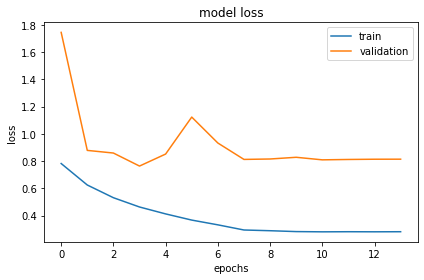

In [6]:
from keras.models import load_model

model = training_model(base_model,final_activation)  

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience=3,verbose = 1)
# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience=patience)

opt_nadam = tf.keras.optimizers.Nadam(1e-5)#Adam with Nestrov momentum

model.compile(optimizer= opt_nadam, loss=loss_function,metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
 

#Initilaising the model
history = model.fit(train_data_generator, steps_per_epoch=len(train_data_generator.classes)//batch_size, validation_data=val_data_generator,epochs = epoch,class_weight = weights,callbacks =[es,reduce_lr],workers = 4)
    
plt_history(history)#model_loss_plot 

**EVALUATION ON TESTDATA**

In [7]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


In [8]:
#saving the actual labels and predictions into cvs files for futher use
import pandas as pd
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual Labels'] = y_test_labels
df.to_csv('FOLD2_500_efficient_test.csv',index = False,header = True)

!cp FOLD2_500_efficient_test.csv "drive/My Drive/"

**AUC ROC curves**

AUC - ROC on Test data average prediction scores: 0.8106995884773662
-----------------------------------------------------


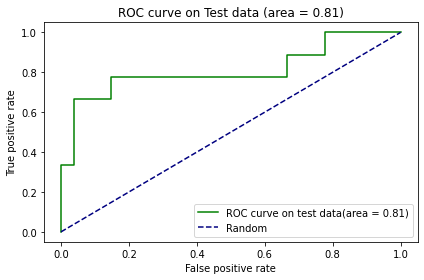

AUC - ROC on Test data maximum prediction scores: 0.6748971193415638
-----------------------------------------------------


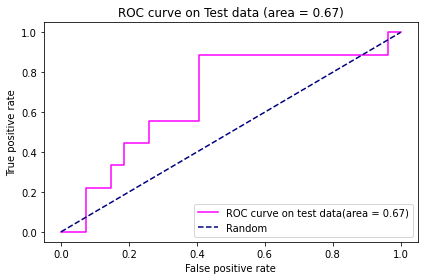

In [9]:
prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

**Presicion Recall Curve**

Presicion - Recall auc on test data average score predictions: 0.7374293076017215
-----------------------------------------------------


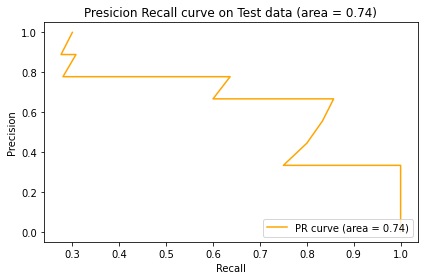

Presicion - Recall auc on test data maximum score predictions: 0.34655381335592894
-----------------------------------------------------


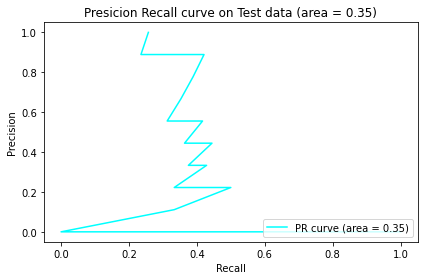

In [10]:
pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

**CLASSIFICATION MATRIX**

In [11]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        27
         1.0       0.67      0.67      0.67         9

    accuracy                           0.83        36
   macro avg       0.78      0.78      0.78        36
weighted avg       0.83      0.83      0.83        36



In [12]:
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.25      1.00      0.40         9

    accuracy                           0.25        36
   macro avg       0.12      0.50      0.20        36
weighted avg       0.06      0.25      0.10        36



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**PREDICTION ON VALIDATION USING AGGREGRATION METHOD**

In [13]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 
        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 46 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))



Prediction on validation using aggregation method


In [14]:
#saving the validation predictions

df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
df_val.to_csv('FOLD2_500_efficient_val.csv',index = False,header = True)

!cp FOLD2_500_efficient_val.csv "drive/My Drive/"

**AUC- ROC Curves**

AUC - ROC on validation data average prediction scores: 0.6323529411764706
-----------------------------------------------------


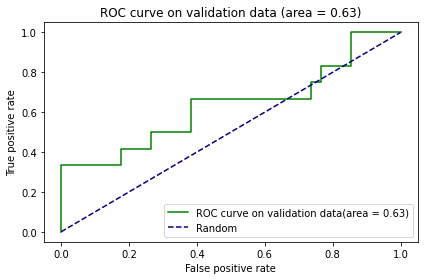

AUC - ROC on validation data maximum prediction scores: 0.6397058823529412
-----------------------------------------------------


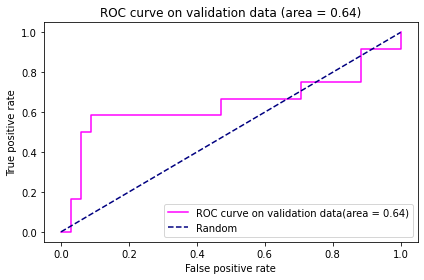

In [15]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()
  
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()
 

Presicion - Recall auc on validation data average score predictions: 0.5478989212192603
-----------------------------------------------------


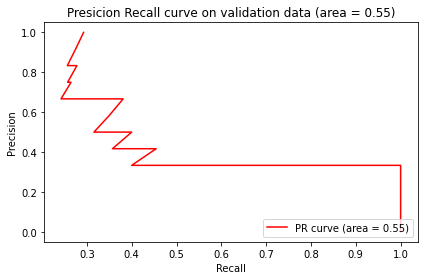

Presicion - Recall auc on validation data maximum score predictions: 0.45458426878098135
-----------------------------------------------------


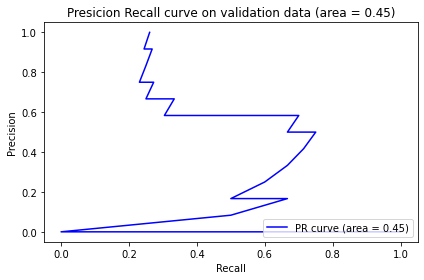

In [16]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [17]:
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85        34
         1.0       0.57      0.33      0.42        12

    accuracy                           0.76        46
   macro avg       0.68      0.62      0.64        46
weighted avg       0.74      0.76      0.74        46



In [18]:
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
         1.0       0.26      1.00      0.41        12

    accuracy                           0.26        46
   macro avg       0.13      0.50      0.21        46
weighted avg       0.07      0.26      0.11        46



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SAVING THE MODEL WEIGHTS**

In [19]:
import pandas as pd

model.save('fold2_efficientnet_500.h5')#saving the model 
!cp fold2_efficientnet_500.h5 "drive/My Drive"